# Demo - Gradient Descent Methods

In [1]:
import sys
sys.path.append('/home/ihler/Dropbox/Code/')
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.set_cmap('jet');
%matplotlib inline

import mltools as ml
import mltools.jupyter
import mltools.datagen

import ipywidgets as widgets
from ipyevents import Event 
from IPython.display import display

## Simple (quadratic) loss:
#### Define the loss function and gradient, and some plotting functions

In [2]:
th0=np.linspace(-2,2,400); th1=np.linspace(-2,2,400);  # Define range of interest & plot resolution
Jth = np.zeros((400,400));

M = np.array([[.4,.3],[.3,.3]]);    # store quadratic term & GD options
class Struct(): pass
opts = Struct();
opts.T = 100; opts.alpha=.5; opts.gamma = 0.; opts.smooth=False; opts.accel=False;

def J(theta):  return theta.dot(M).dot(theta)
def dJ(theta): return 2*theta.dot(M)

def set_opts(T,alpha,gamma,smooth,accel):
    opts.T = T; opts.alpha=alpha; opts.gamma=gamma; opts.smooth=smooth; opts.accel=accel;

def set_M(sig00,sig11,rho): 
    M[0,:] = [sig00,-rho*np.sqrt(sig00*sig11)]; M[1,:]=[-rho*np.sqrt(sig00*sig11),sig11];
    for i,t0 in enumerate(th0):
        for j,t1 in enumerate(th1):
            Jth[i,j] = J(np.array([t0,t1]))

#### Gradient Descent function; includes:
* Step size (constant) alpha
* Momentum (geometric decrease) gamma
* Estimate smoothing
* "Accelerated" gradient

In [3]:
def plot_GD(th0,th1,Jth,X,T,alpha0,gamma,accel,smooth):
    plt.contour(th0,th1,Jth.T,cmap='jet', levels=np.percentile(Jth.reshape((-1,)),[1,5,10,20,40,60,80,95]));
    plt.axis([th0[0],th0[-1],th1[0],th1[-1]]);
    if (not len(X)): return;
    
    for i in range(len(X)):
        theta=np.zeros((T,2)); theta[0,:]=X[i:i+1,:]; Gt = 0*theta[0,:]; 
        for it in range(T-1):
            alpha = alpha0;  # use any schedule?
            dJ_at = theta[it,:] if not accel else theta[it,:]-alpha*gamma*Gt;
            Gt = gamma*Gt + dJ(dJ_at);
            theta[it+1,:]=theta[it,:]-alpha*Gt
        if smooth: theta = np.cumsum(theta,axis=0)/(1+np.arange(T))[:,np.newaxis];
        plt.plot(theta[:,0],theta[:,1],'.-',color=(.65,.65,.65),ms=14);
        plt.plot(theta[-1,0],theta[-1,1],'.',color=(0,0,0),ms=14);
    # todo: optional add momentum, next gradient vectors at last point?

#### Interactive demo
* Click to place initial parameters
* Change spread & correlation of the quadratic loss
* Change options (# steps T; step size alpha; momentum gamma; smoothing & accelerated options)

In [4]:
sig00 = widgets.FloatSlider(value=M[0,0], min=.01,max=3,step=.05, description='sig00')
sig11 = widgets.FloatSlider(value=M[1,1], min=.001,max=3,step=.05, description='sig11')
rho   = widgets.FloatSlider(value=-np.sqrt(M[0,1]**2/M[0,0]/M[1,1]), min=-1,max=1,step=.05, description='rho');

T = widgets.IntSlider(100,description='T');
alpha = widgets.FloatLogSlider(value=.5, min=-3,max=1,step=.01, description='alpha')
gamma = widgets.FloatSlider(min=0,max=1,step=.01, description='gamma')
smooth = widgets.Checkbox(value=False, description='smooth')
accel  = widgets.Checkbox(value=False, description='accel')

# Use initial M, populate Jth array values:
set_M(M[0,0],M[1,1],-np.sqrt(M[0,1]**2/M[0,0]/M[1,1]));

# Generate interactive plot elements: contour image, controls:  !!! 2x for desired plot range
data = ml.jupyter.data_mouse(plot=lambda X,Y: plot_GD(th0,th1,Jth,2*X[-1:,:],opts.T,opts.alpha,opts.gamma,opts.accel,opts.smooth))
#data = ml.datagen.MouseDataWidget(plot=lambda X,Y: plot_GD(th0,th1,Jth,2*X[-1:,:],opts.T,opts.alpha,opts.gamma,opts.accel,opts.smooth))
     
_ = widgets.interactive_output(set_M, {'sig00': sig00, 'sig11': sig11, 'rho': rho})
_ = widgets.interactive_output(set_opts, {'T': T, 'alpha': alpha, 'gamma': gamma, 'smooth':smooth, 'accel':accel})
controls = widgets.VBox([widgets.Label("Loss function:"),sig00,sig11,rho, 
                         widgets.Label("Grad Descent:"),T,alpha,gamma,smooth,accel])

hbox = widgets.HBox([data.image,controls])
display(hbox)

<Figure size 432x432 with 0 Axes>

In [7]:
# Some useful values to try as examples:

# Nice oscillation: Sig=[1.46,1.25, -.7]; alpha = .427; gamma = 0  (increase to .1 to smooth)


----
----

## Losses with local optima
An example non-convex loss:

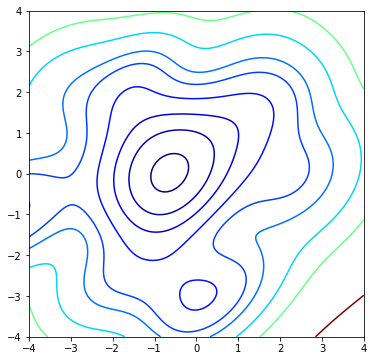

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import mltools as ml
import mltools.datagen
np.random.seed(2)

plt.figure(figsize=(6,6))
x1,x2 = np.linspace(-4,4,200), np.linspace(-4,4,200);
mg = np.meshgrid(x1,x2); X12 = np.hstack((mg[0].reshape(-1,1),mg[1].reshape(-1,1)));
mix = ml.datagen.gmm_draw_params(None,20,n=2, scale=.3)
#mix = ((.75,np.array([-1,-2]),np.array([[1,.3],[.3,1]])),(.25,np.array([1,1]),np.array([[.3,0],[0,.3]])))

LL = ml.datagen.gmm_nll(X12, mix);
#plt.imshow(np.exp(-LL.reshape(200,200).T)); plt.axis('off'); plt.show();
levels = LL.min()+np.array([.9]+[1.25**a+.1 for a in np.arange(15)])
levels = np.percentile(LL.reshape(-1), [1,5,10,20,40,55,75,90,99])
plt.contour(x1,x2,LL.reshape(200,200), levels=levels); #[1,2,3,4,5,8,10,12,15,18,21,25,30] )

We can look at its gradient field:

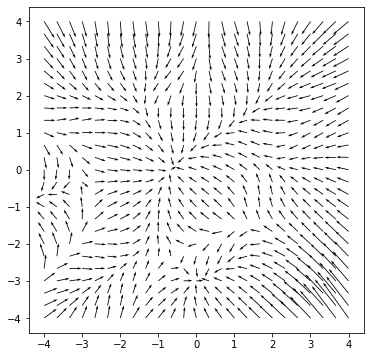

In [7]:
import mltools.datagen
np.random.seed(2)

plt.figure(figsize=(6,6))
res = 25;
x1,x2 = np.linspace(-4,4,res), np.linspace(-4,4,res);
mg = np.meshgrid(x1,x2); X12 = np.hstack((mg[0].reshape(-1,1),mg[1].reshape(-1,1)));
mix = ml.datagen.gmm_draw_params(None,20,n=2, scale=.3)

dX = -ml.datagen.gmm_nll_dX(X12, mix);
sc = np.sqrt((dX**2).sum(1,keepdims=True))
dX /= np.median(sc)*(sc/np.median(sc))**(7./8)  # flatten quiver lengths ~ 1
plt.quiver(x1,x2,dX[:,0].reshape(res,res),dX[:,1].reshape(res,res),angles='xy',scale=30.);

and can do interactive gradient descent on the loss:

In [8]:
import ipywidgets as widgets
from ipyevents import Event 
from IPython.display import display
import mltools.jupyter

th0=np.linspace(-4,4,400); th1=np.linspace(-4,4,400);  # Define range of interest & plot resolution
Jth = np.zeros((400,400));
            
class Struct(): pass
opts = Struct();
opts.T = 100; opts.alpha=.005; opts.gamma = 0.; opts.smooth=False; opts.accel=False;

def J(X):  return 0 if not len(X) else ml.datagen.gmm_nll(X.reshape(-1,2), mix);
def dJ(X): return None if not len(X) else ml.datagen.gmm_nll_dX(X.reshape(-1,2),mix);

def set_opts(T,alpha,gamma,smooth,accel):
    opts.T = T; opts.alpha=alpha; opts.gamma=gamma; opts.smooth=smooth; opts.accel=accel;

mg = np.meshgrid(th0,th1); X12 = np.hstack((mg[0].reshape(-1,1),mg[1].reshape(-1,1)));
Jth = ml.datagen.gmm_nll(X12, mix).reshape(400,400).T;   

In [9]:
T = widgets.IntSlider(100,description='T');
alpha = widgets.FloatLogSlider(value=opts.alpha, min=-3,max=1,step=.01, description='alpha')
gamma = widgets.FloatSlider(min=0,max=1,step=.01, description='gamma')
smooth = widgets.Checkbox(value=False, description='smooth')
accel  = widgets.Checkbox(value=False, description='accel')

# Generate interactive plot elements: contour image, controls:  !!! 4x for desired plot range
data = ml.jupyter.data_mouse(plot=lambda X,Y: plot_GD(th0,th1,Jth,4*X[-1:,:],opts.T,opts.alpha,opts.gamma,opts.accel,opts.smooth))
        
_ = widgets.interactive_output(set_opts, {'T': T, 'alpha': alpha, 'gamma': gamma, 'smooth':smooth, 'accel':accel})
controls = widgets.VBox([widgets.Label("Grad Descent:"),T,alpha,gamma,smooth,accel])

hbox = widgets.HBox([data.image,controls])
display(hbox)

<Figure size 432x432 with 0 Axes>